In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    multilabel_confusion_matrix,
    f1_score,
    hamming_loss,
    jaccard_score,
)
from sklearn.model_selection import KFold

### Data & Visualisation

Multi-label classification

1024 instances

10 genese

In [2]:
# We load from pre-processed data

full_data = np.load("/data/public/boolean_networks/mam/mam_raw_data.npy")

### Common code

In [3]:
# Config
NUM_FOLD = 10
RANDOM_STATE = 73

In [4]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [5]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
    print_cm: bool = False,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")

    # K-Fold
    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    fold_hamming_loss = []
    fold_micro_f1 = []
    fold_micro_jaccard = []

    for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
        train_X = full_data[train_index, 0]
        train_y = full_data[train_index, 1]
        test_X = full_data[test_index, 0]
        test_y = full_data[test_index, 1]

        model.fit(train_X, train_y)

        y_pred = model.predict(test_X)

        hamming_loss_score = hamming_loss(test_y, y_pred)
        micro_f1 = f1_score(test_y, y_pred, average="micro")
        micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

        fold_hamming_loss.append(hamming_loss_score)
        fold_micro_f1.append(micro_f1)
        fold_micro_jaccard.append(micro_jaccard)

        print(
            f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
        )

        if print_cm:
            cm = multilabel_confusion_matrix(test_y, y_pred)
            print(cm)


    print("\nCross-Validation Results:")
    print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
    print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
    print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")


## Random forest

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=72)
binary_classification(model, "Random Forest")

Model Random Forest with 10-fold cross-validation

Fold 0: F1=1.0000, Jaccard=1.0000, Hamming=0.0000
Fold 1: F1=0.9948, Jaccard=0.9897, Hamming=0.0039
Fold 2: F1=0.9957, Jaccard=0.9915, Hamming=0.0029
Fold 3: F1=1.0000, Jaccard=1.0000, Hamming=0.0000
Fold 4: F1=0.9959, Jaccard=0.9917, Hamming=0.0029
Fold 5: F1=0.9972, Jaccard=0.9945, Hamming=0.0020
Fold 6: F1=0.9987, Jaccard=0.9973, Hamming=0.0010
Fold 7: F1=0.9986, Jaccard=0.9973, Hamming=0.0010
Fold 8: F1=0.9986, Jaccard=0.9972, Hamming=0.0010
Fold 9: F1=1.0000, Jaccard=1.0000, Hamming=0.0000

Cross-Validation Results:
Mean Hamming Loss: 0.001 ± 0.000
Mean Micro F1: 0.998 ± 0.001
Mean Micro Jaccard: 0.996 ± 0.001


## Decision tree

In [7]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

In [8]:
model = DecisionTreeClassifier(random_state=74, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
kf = KFold(n_splits=NUM_FOLD, shuffle=True, random_state=RANDOM_STATE)

fold_hamming_loss = []
fold_micro_f1 = []
fold_micro_jaccard = []
tree_stats: list[dict[str, float]] = []

for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
    train_X = full_data[train_index, 0]
    train_y = full_data[train_index, 1]
    test_X = full_data[test_index, 0]
    test_y = full_data[test_index, 1]
    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    hamming_loss_score = hamming_loss(test_y, y_pred)
    micro_f1 = f1_score(test_y, y_pred, average="micro")
    micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_hamming_loss.append(hamming_loss_score)
    fold_micro_f1.append(micro_f1)
    fold_micro_jaccard.append(micro_jaccard)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
    )


print("\nCross-Validation Results:")
print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

Decision tree with 10-fold cross-validation

Fold 0: F1=0.9368, Jaccard=0.8811, Hamming=0.0476
Fold 1: F1=0.9499, Jaccard=0.9046, Hamming=0.0379
Fold 2: F1=0.9553, Jaccard=0.9144, Hamming=0.0311
Fold 3: F1=0.9523, Jaccard=0.9089, Hamming=0.0350
Fold 4: F1=0.9479, Jaccard=0.9010, Hamming=0.0373
Fold 5: F1=0.9607, Jaccard=0.9243, Hamming=0.0284
Fold 6: F1=0.9549, Jaccard=0.9137, Hamming=0.0333
Fold 7: F1=0.9421, Jaccard=0.8906, Hamming=0.0422
Fold 8: F1=0.9573, Jaccard=0.9180, Hamming=0.0294
Fold 9: F1=0.9385, Jaccard=0.8841, Hamming=0.0422

Cross-Validation Results:
Mean Hamming Loss: 0.036 ± 0.002
Mean Micro F1: 0.950 ± 0.002
Mean Micro Jaccard: 0.904 ± 0.004

Tree Stats:
Avg Max Depth: 10.000 ± 0.000
Avg Avg Depth: 8.970 ± 0.018
Avg Branches: 424.200 ± 5.261


<Figure size 640x480 with 0 Axes>

[Text(0.4056295321132597, 0.9545454545454546, 'x[8] <= 0.5\ngini = 0.265\nsamples = 922\nvalue = [[5307.992, 325.197]\n[1147.87, 4485.319]\n[459.047, 5174.141]\n[382.021, 5251.168]\n[756.231, 4876.958]\n[844.305, 4788.884]\n[5472.746, 160.443]\n[1811.448, 3821.74]\n[3148.042, 2485.146]\n[2091.698, 3541.49]]'),
 Text(0.17442161602209943, 0.8636363636363636, 'x[4] <= 0.5\ngini = 0.172\nsamples = 468\nvalue = [[3465.946, 218.243]\n[715.844, 2968.345]\n[308.176, 3376.012]\n[238.254, 3445.934]\n[291.405, 3392.783]\n[565.444, 3118.745]\n[3571.173, 113.016]\n[0.0, 3684.189]\n[2146.838, 1537.35]\n[142.698, 3541.49]]'),
 Text(0.2900255740676796, 0.9090909090909092, 'True  '),
 Text(0.07924723756906077, 0.7727272727272727, 'x[0] <= 0.5\ngini = 0.112\nsamples = 237\nvalue = [[1435.861, 79.665]\n[134.43, 1381.096]\n[116.183, 1399.343]\n[87.35, 1428.176]\n[204.29, 1311.236]\n[116.183, 1399.343]\n[1467.082, 48.444]\n[0.0, 1515.526]\n[34.765, 1480.762]\n[99.934, 1415.592]]'),
 Text(0.0466160220994475

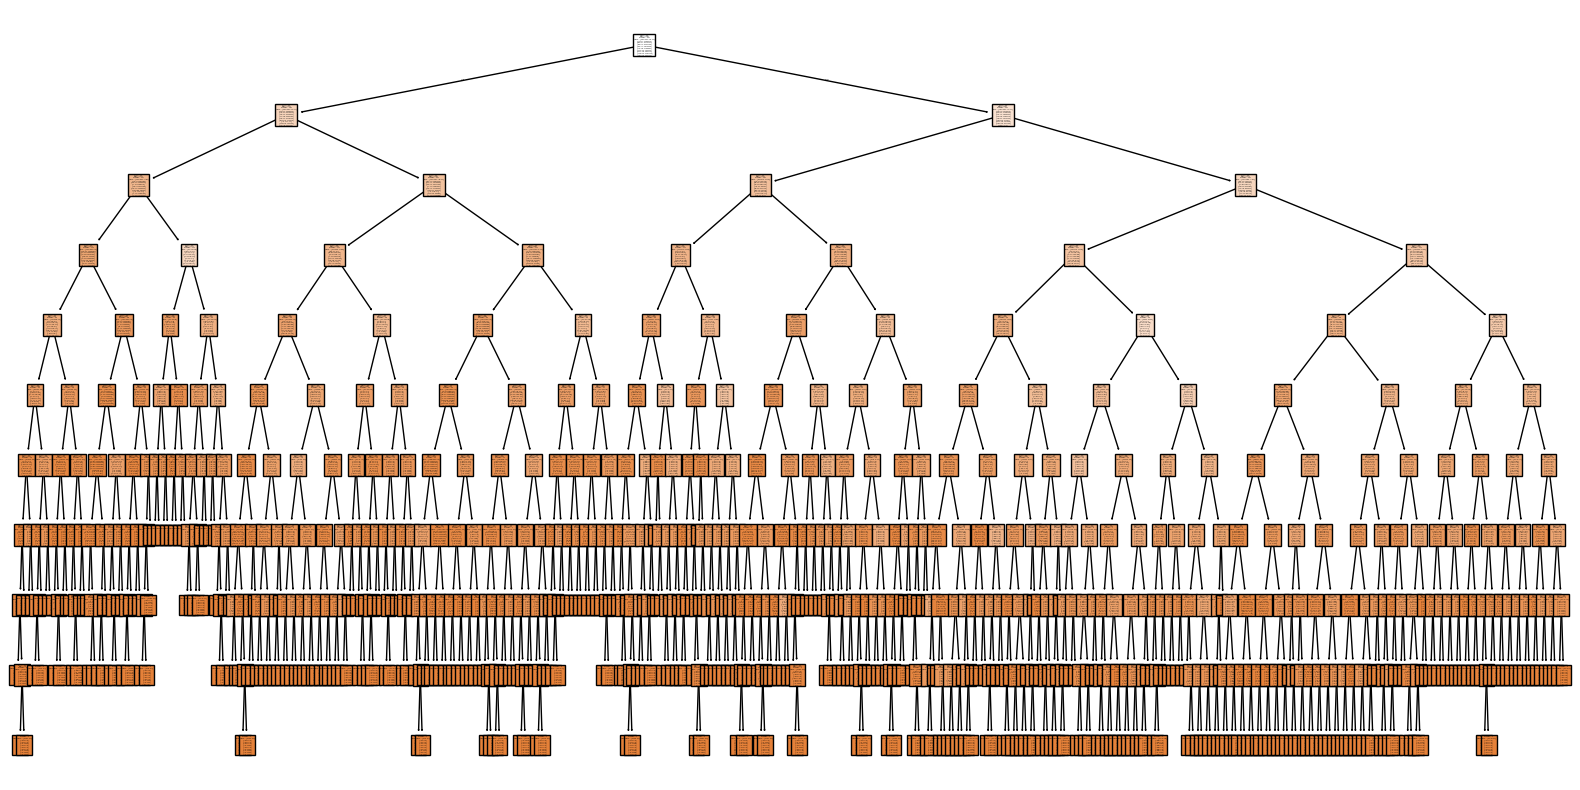

In [9]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True)